<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    System 2 - Homework 3<br>
<font color=2565AE size=5>
    Spring 2025<br>
<font color=3C99D size=5>
    Graph RAG <br>

*`Full Name:`* Radin Cheraghi

*`SID:`* 401105815


----




In this Notebook, we'll explore the implementation of the GraphRAG (Graph-based Retrieval-Augmented Generation) approach to query-focused summarization, as described in the research paper `"From Local to Global: A GraphRAG Approach to Query-Focused Summarization"` by Darren Edge et al. This method is designed to generate comprehensive and diverse answers to global questions over entire text corpora by leveraging a graph-based text index and an LLM (Large Language Model).

We'll walk through a Python-based implementation that includes key steps from the paper, demonstrating how to process documents, build a graph, detect communities, and generate a final answer to a query.

Overview of the proposed Pipeline:
![GraphRAG](https://drive.google.com/uc?export=view&id=16Pv1vt_yY6u9ARodmnkbRmQttcpnjB18)

In [1]:
!pip install -q networkx leidenalg cdlib python-igraph pypdf

In [2]:
%%capture --no-stderr
!pip install langchain-opentutorial

In [3]:
from langchain_opentutorial import package

package.install(
    [
        "langchain_core",
        "langchain_community",
        "langchain-graphrag",

    ],
    verbose=False,
    upgrade=False,
)

In [4]:
# Download and save sample PDF file to ./data directory
import requests
import os

def download_pdf(url, save_path):
    """
    Downloads a PDF file from the given URL and saves it to the specified path.

    Args:
        url (str): The URL of the PDF file to download.
        save_path (str): The full path (including file name) where the file will be saved.
    """
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # Download the file
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error for bad status codes

        # Save the file to the specified path
        with open(save_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

        print(f"PDF downloaded and saved to: {save_path}")
    except Exception as e:
        print(f"An error occurred while downloading the file: {e}")

# Configuration for the PDF file
pdf_url = "https://arxiv.org/pdf/2404.16130v1"
file_path = "./data/2404.16130v1.pdf"

# Download the PDF
download_pdf(pdf_url, file_path)

# Load the GraphRAG paper using PyPDFLoader.
# PyPDFLoader loads PDF content on a per-page basis.
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
docs = loader.load()
print(f"Loaded {len(docs)} documents.")
print(docs[0].page_content)

PDF downloaded and saved to: ./data/2404.16130v1.pdf
Loaded 15 documents.
From Local to Global: A Graph RAG Approach to
Query-Focused Summarization
Darren Edge1† Ha Trinh1† Newman Cheng2 Joshua Bradley2 Alex Chao3
Apurva Mody3 Steven Truitt2
Jonathan Larson1
1Microsoft Research
2Microsoft Strategic Missions and Technologies
3Microsoft Office of the CTO
{daedge,trinhha,newmancheng,joshbradley,achao,moapurva,steventruitt,jolarso}
@microsoft.com
†These authors contributed equally to this work
Abstract
The use of retrieval-augmented generation (RAG) to retrieve relevant informa-
tion from an external knowledge source enables large language models (LLMs)
to answer questions over private and/or previously unseen document collections.
However, RAG fails on global questions directed at an entire text corpus, such
as “What are the main themes in the dataset?”, since this is inherently a query-
focused summarization (QFS) task, rather than an explicit retrieval task. Prior
QFS methods, meanwhile

In [5]:
from langchain_core.documents import Document
from langchain_graphrag.indexing import TextUnitExtractor
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=100)
text_unit_extractor = TextUnitExtractor(text_splitter=splitter)

# This runs the text splitting logic on the loaded PDF pages
df_text_units = text_unit_extractor.run(docs)
df_text_units

Extracting text units ...: 100%|██████████| 6/6 [00:00<00:00, 25890.77it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 60133.39it/s]

Extracting text units ...: 100%|██████████| 7/7 [00:00<00:00, 62335.73it/s]

Extracting text units ...: 100%|██████████| 9/9 [00:00<00:00, 63443.25it/s]

Extracting text units ...: 100%|██████████| 7/7 [00:00<00:00, 61680.94it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 21592.30it/s]

Extracting text units ...: 100%|██████████| 9/9 [00:00<00:00, 72315.59it/s]

Extracting text units ...: 100%|██████████| 10/10 [00:00<00:00, 72315.59it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 22504.65it/s]

Extracting text units ...: 100%|██████████| 9/9 [00:00<00:00, 71493.82it/s]

Extracting text units ...: 100%|██████████| 9/9 [00:00<00:00, 65764.35it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 57260.12it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 68338.97it/s

,document_id,id,text_unit
0,0a8ef75e-71dc-4fa9-998f-75f6e14be42d,d0222507-7877-4a78-a452-952517cdd089,From Local to Global: A Graph RAG Approach to\...
1,0a8ef75e-71dc-4fa9-998f-75f6e14be42d,8c57669f-d9b9-405f-96b4-7f3bdc7e7fb1,tion from an external knowledge source enables...
2,0a8ef75e-71dc-4fa9-998f-75f6e14be42d,40368bdd-5ec0-48ac-8ee9-e05d32c17dcf,RAG systems. To combine the strengths of these...
3,0a8ef75e-71dc-4fa9-998f-75f6e14be42d,bfc24ed6-b46a-4a01-9382-11252a45eb00,"question, each community summary is used to ge..."
4,0a8ef75e-71dc-4fa9-998f-75f6e14be42d,2b0d71d3-695c-4286-a8b0-072fcf3292c3,approaches is forthcoming at https://aka.ms/gr...
...,...,...,...
110,4842c452-5abd-4344-9dfb-0e1bf10af6e6,036f9bd4-cc7a-4314-8f2d-0591c5fa22a4,well-connected communities. Scientific Reports...
111,4842c452-5abd-4344-9dfb-0e1bf10af6e6,c3e157c9-1e26-4f60-ba63-30a07ce7fbda,a good nlg evaluator? a preliminary study. arX...
112,4842c452-5abd-4344-9dfb-0e1bf10af6e6,ef1bb182-18d0-4297-b2d6-4a4b71129635,"arXiv:2106.00104.\nYang, Z., Qi, P., Zhang, S...."
113,4bdb8487-39a2-4c53-9fc3-c9ca05501bf0,5a88cbfc-7043-4eef-b0e2-e43407f5d875,"Yao, L., Peng, J., Mao, C., and Luo, Y . (2023..."


In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import networkx as nx
from cdlib import algorithms
import os


model_name = "Qwen/Qwen3-4B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
def get_response(prompt, content):
    messages = [
    {"role": "user", "content": content + ' Do not include any additional and irrelevant information. \t' + prompt}
]
    text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False # Switches between thinking and non-thinking modes. Default is True.
)
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=32768
    )
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=32768
    )
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

    response = tokenizer.decode(output_ids[0:], skip_special_tokens=True).strip("\n")
    return response

get_response('hi', '')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap'}


tokenizer_config.json:   0%|          | 0.00/9.73k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

'hi'

`1. Text Chunks → Element Instances`

  First, we'll extract entities and relationships from each chunk of text using Qwen

In [13]:
def extract_element_Instances(chunks):
    """
      Inputs:
        chunks (list of str): List of text chunks.
      Output:
        List of extracted elements (entity-relationship data).
    """
    # One shot approach has been used in the following prompt.
    prompt_template = (
        "You are an information extraction assistant.\n"
        "Given a scientific passage, extract the named entities and describe their relationships.\n\n"
        "**Example Input:**\n"
        "\"Darren Edge and Ha Trinh contributed to the paper titled 'GraphRAG'. "
        "It was published by Microsoft Research.\"\n\n"
        "**Example Output:**\n"
        "**Entities:**\n"
        "- Darren Edge\n"
        "- Ha Trinh\n"
        "- GraphRAG\n"
        "- Microsoft Research\n\n"
        "**Relationships:**\n"
        "- Darren Edge and Ha Trinh are authors of the paper 'GraphRAG'.\n"
        "- The paper 'GraphRAG' was published by Microsoft Research.\n\n"
        "Now extract from the following passage:\n\n"
    )

    elements = []

    for index, chunk in enumerate(chunks):
        print(f"Processing chunk {index + 1} of {len(chunks)}...")
        full_prompt = f"{prompt_template}{chunk}"
        response = get_response("", full_prompt)
        print(response)
        elements.append(response)

    return elements


elements = extract_element_Instances(df_text_units['text_unit'][:15])

Processing chunk 1 of 15...
**Entities:**
- From Local to Global: A Graph RAG Approach to Query-Focused Summarization (Title of the paper)
- Darren Edge
- Ha Trinh
- Newman Cheng
- Joshua Bradley
- Alex Chao
- Apurva Mody
- Steven Truitt
- Jonathan Larson
- Microsoft Research
- Microsoft Strategic Missions and Technologies
- Microsoft Office of the CTO
- @microsoft.com

**Relationships:**
- Darren Edge, Ha Trinh, Newman Cheng, Joshua Bradley, Alex Chao, Apurva Mody, Steven Truitt, and Jonathan Larson are authors of the paper "From Local to Global: A Graph RAG Approach to Query-Focused Summarization".
- Darren Edge and Ha Trinh contributed equally to this work.
- The paper "From Local to Global: A Graph RAG Approach to Query-Focused Summarization" is associated with Microsoft Research.
- Microsoft Strategic Missions and Technologies is an affiliation of Newman Cheng, Joshua Bradley, Alex Chao, Apurva Mody, and Steven Truitt.
- Microsoft Office of the CTO is an affiliation of Alex Chao, 

`2. Element Instances → Element Summaries`

  Summarize the extracted entities and relationships into a structured format

In [14]:
def summarize_element_Instances(elements):
    """
      Summarizes entity-relationship data into a structured format.
      Inputs:
        elements (list): List of extracted entity-relationship data.
      Output:
        List of structured summaries as strings.
    """
    summaries = []

    prompt_template = (
        "Given the following extracted entities and relationships, summarize them in a structured format.\n"
        "List the entities under 'Entities:', and use '->' to express each relationship under 'Relationships:'.\n\n"
    )
    for index, element in enumerate(elements):
        print(f"Processing element {index + 1} of {len(elements)}...")
        full_prompt = f"{prompt_template}{element}"
        response = get_response("", full_prompt)

        print("Element summary:", response)
        summary = response
        summaries.append(summary)
    return summaries


summaries = summarize_element_Instances(elements)

Processing element 1 of 15...
Element summary: **Entities:**  
- From Local to Global: A Graph RAG Approach to Query-Focused Summarization  
- Darren Edge  
- Ha Trinh  
- Newman Cheng  
- Joshua Bradley  
- Alex Chao  
- Apurva Mody  
- Steven Truitt  
- Jonathan Larson  
- Microsoft Research  
- Microsoft Strategic Missions and Technologies  
- Microsoft Office of the CTO  
- @microsoft.com  

**Relationships:**  
- Darren Edge -> is an author of "From Local to Global: A Graph RAG Approach to Query-Focused Summarization"  
- Ha Trinh -> is an author of "From Local to Global: A Graph RAG Approach to Query-Focused Summarization"  
- Newman Cheng -> is an author of "From Local to Global: A Graph RAG Approach to Query-Focused Summarization"  
- Joshua Bradley -> is an author of "From Local to Global: A Graph RAG Approach to Query-Focused Summarization"  
- Alex Chao -> is an author of "From Local to Global: A Graph RAG Approach to Query-Focused Summarization"  
- Apurva Mody -> is an aut

`3. Element Summaries → Graph Communities`

  build a graph from the element summaries and detect communities using the $\href {https://en.wikipedia.org/wiki/Leiden_algorithm}{Leiden algorithm}$.



In [15]:
def parse_entities(lines):
    entities = []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if line[0].isdigit() and line[1:3] == ". ":
            line = line.split(".", 1)[1].strip()
        entity = line.replace("**", "").strip()
        entities.append(entity)
    return entities


def parse_relationships(lines, graph):
    for line in lines:
        line = line.strip()
        if not line:
            continue
        parts = line.split("->")
        if len(parts) >= 2:
            source = parts[0].strip()
            target = parts[-1].strip()
            relation = " -> ".join(p.strip() for p in parts[1:-1]) or "related_to"
            graph.add_edge(source, target, label=relation)


def graph_building(summaries):
    G = nx.Graph()

    for index, summary in enumerate(summaries):
        print(f"Summary index {index + 1} of {len(summaries)}:")
        lines = summary.split("\n")
        entities_section = False
        relationships_section = False
        entity_lines = []
        relationship_lines = []

        for line in lines:
            if line.startswith(("### Entities:", "**Entities:**")):
                entities_section = True
                relationships_section = False
                continue
            elif line.startswith(("### Relationships:", "**Relationships:**")):
                entities_section = False
                relationships_section = True
                continue

            if entities_section:
                entity_lines.append(line)
            elif relationships_section:
                relationship_lines.append(line)

        entities = parse_entities(entity_lines)
        for entity in entities:
            G.add_node(entity)

        parse_relationships(relationship_lines, G)

    return G


# Usage
graph = graph_building(summaries)
print(f"Graph has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")

Summary index 1 of 15:
Summary index 2 of 15:
Summary index 3 of 15:
Summary index 4 of 15:
Summary index 5 of 15:
Summary index 6 of 15:
Summary index 7 of 15:
Summary index 8 of 15:
Summary index 9 of 15:
Summary index 10 of 15:
Summary index 11 of 15:
Summary index 12 of 15:
Summary index 13 of 15:
Summary index 14 of 15:
Summary index 15 of 15:
Graph has 182 nodes and 100 edges.


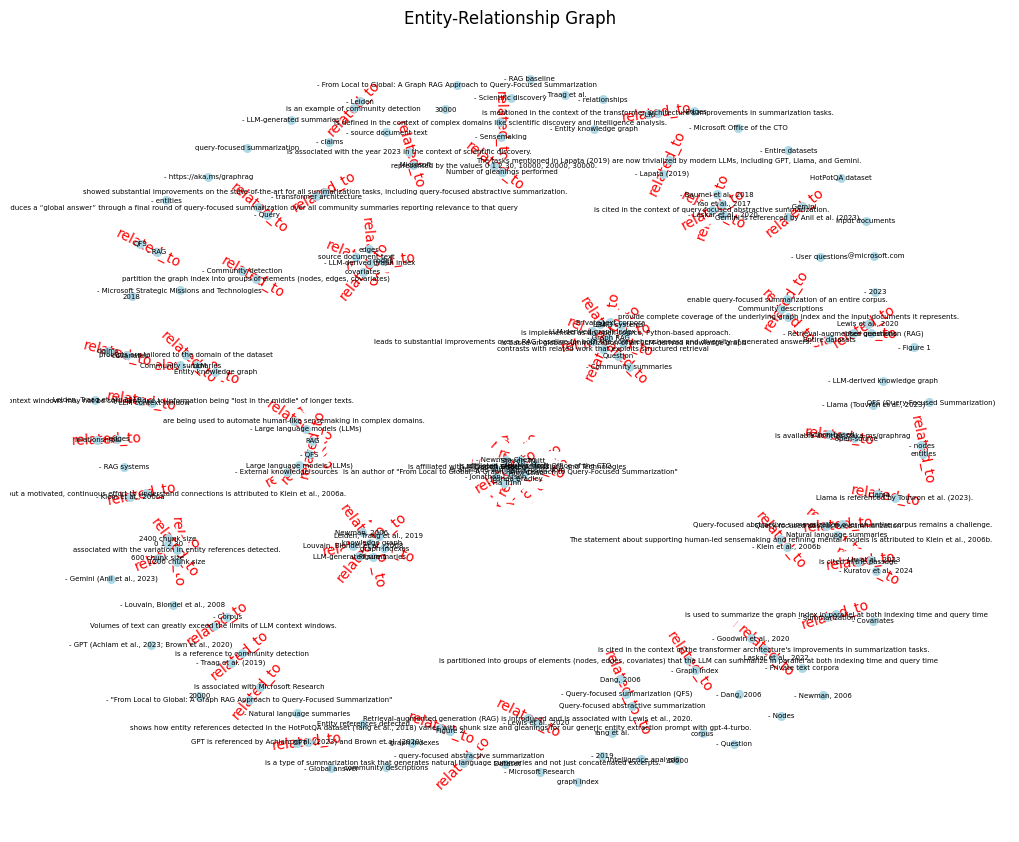

In [16]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(graph)
labels = nx.get_edge_attributes(graph, 'label')

plt.figure(figsize=(10, 8))
nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=30, font_size=5, edge_color='gray')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_color='red')
plt.title("Entity-Relationship Graph")
plt.show()


In [17]:
def detect_communities_in_subgraph(subgraph, index):
    if len(subgraph.nodes) <= 1:
        return [list(subgraph.nodes)]

    try:
        result = algorithms.leiden(subgraph)
        return [list(community) for community in result.communities]
    except Exception as e:
        print(f"Error processing community {index}: {e}")
        return []


def communities_detection(graph):
    all_communities = []
    components = list(nx.connected_components(graph))

    for index, component_nodes in enumerate(components):
        print(f"Component index {index} of {len(components)}:")
        subgraph = graph.subgraph(component_nodes)
        communities = detect_communities_in_subgraph(subgraph, index)
        all_communities.extend(communities)

    print("Communities from detect_communities:", all_communities)
    return all_communities


communities = communities_detection(graph)

Component index 0 of 95:
Component index 1 of 95:
Error processing community 1: invalid literal for int() with base 10: '- Newman Cheng'
Component index 2 of 95:
Component index 3 of 95:
Component index 4 of 95:
Component index 5 of 95:
Component index 6 of 95:
Error processing community 6: invalid literal for int() with base 10: '- "From Local to Global: A Graph RAG Approach to Query-Focused Summarization"'
Component index 7 of 95:
Error processing community 7: invalid literal for int() with base 10: 'are being used to automate human-like sensemaking in complex domains.'
Component index 8 of 95:
Error processing community 8: invalid literal for int() with base 10: '- RAG'
Component index 9 of 95:
Component index 10 of 95:
Component index 11 of 95:
Error processing community 11: invalid literal for int() with base 10: 'RAG systems'
Component index 12 of 95:
Error processing community 12: invalid literal for int() with base 10: 'Community summaries'
Component index 13 of 95:
Component i

`4. Graph Communities → Community Summaries`

  summarize each detected community.

In [18]:
def format_community_description(nodes, edges):
    entity_str = "Entities:\n" + ", ".join(nodes)
    relationship_str = "Relationships:\n"

    relationship_lines = []
    for source, target, data in edges:
        relation = data.get("label", "related_to")
        relationship_lines.append(f"{source} -> {relation} -> {target}")

    return f"{entity_str}\n\n{relationship_str}" + "\n".join(relationship_lines)


def communities_summerization(communities, graph):
    summaries = []

    for index, community_nodes in enumerate(communities):
        print(f"Summarizing Community {index + 1} of {len(communities)}")
        subgraph = graph.subgraph(community_nodes)
        nodes = list(subgraph.nodes)
        edges = list(subgraph.edges(data=True))

        description = format_community_description(nodes, edges)
        prompt = "Summarize the following community of entities and relationships:"
        summary = get_response(prompt, description)

        print("Community summary:", summary)
        summaries.append(summary)

    return summaries


community_summaries = communities_summerization(communities, graph)

Summarizing Community 1 of 53
Community summary: The community consists of a single entity: "From Local to Global: A Graph RAG Approach to Query-Focused Summarization." This entity represents a research or methodological approach that uses a graph-based Retrieval-Augmented Generation (RAG) system to perform query-focused summarization. The approach transitions from local to global information, leveraging graph structures to enhance the summarization process by integrating both local details and broader contextual information. No additional relationships or entities are included.
Summarizing Community 2 of 53
Community summary: Microsoft Research is a research organization that conducts scientific and technological research. It is associated with Microsoft, a global technology company. The relationship between Microsoft Research and Microsoft is that Microsoft Research is a part of Microsoft, focusing on advanced research in various fields such as artificial intelligence, machine learni

`6. Community Summaries → Community Answers → Global Answer`

  Finally, we generate answers from community summaries and combine them into a final global answer.

In [19]:
def generate_intermediate_answers(community_summaries, query):
    intermediate_answers = []

    for i, summary in enumerate(community_summaries):
        print(f"Processing summary {i + 1} of {len(community_summaries)}...")
        prompt = (
            f"Query: {query}\n\n"
            f"Summary: {summary}\n\n"
            "Using only the information in the summary above, answer the user's query as accurately and concisely as possible."
        )
        answer = get_response("", prompt).strip()
        print("Intermediate answer:", answer)
        intermediate_answers.append(answer)

    return intermediate_answers


def generate_final_answer(community_summaries, query):
    intermediate_answers = generate_intermediate_answers(community_summaries, query)

    aggregation_prompt = (
        "You are an expert assistant. Combine the following partial answers into one coherent, complete, and concise response that fully answers the user's question. "
        "Remove any repetition and ensure clarity.\n\n"
        f"Question: {query}\n\n"
        "Partial Answers:\n" +
        "\n\n".join(f"- {ans}" for ans in intermediate_answers)
    )

    final_answer = get_response("", aggregation_prompt).strip()
    return final_answer

#### Analyze the proposed method for these questions. `10 pts`

- What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?

- How does the Graph RAG architecture overcome the limitations of LLM context windows?

- What are the key steps in the Graph RAG pipeline, and how are they distributed between indexing time and query time?

- How does Graph RAG differ from previous QFS or graph-based retrieval approaches?

- What role do community detection algorithms (e.g., Leiden or Louvain) play in the Graph RAG framework?

- How does the performance of Graph RAG scale with increasing corpus size (e.g., 1M tokens)?

- What kind of summaries are generated during each stage of the Graph RAG pipeline, and how are they used?

- Why is the distinction between ‘local’ and ‘global’ queries important in the design of Graph RAG?

- How does entity extraction using GPT-4-turbo vary with chunk sizes in the HotPotQA dataset, as shown in Figure 2?

- Why do the authors claim that query-focused abstractive summarization is more appropriate than retrieval-based generation for global questions?

- In what ways does the modularity of graphs enable better summarization in the context of large corpora?

- How does Graph RAG contribute to the broader goal of sensemaking in domains like scientific discovery or intelligence analysis?

In [20]:
query = "What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?
Processing summary 1 of 53...
Intermediate answer: Graph RAG aims to solve the problem of limited contextual integration in traditional RAG and QFS methods by leveraging graph structures to better combine local details with global contextual information, thereby improving the quality of query-focused summarization.
Processing summary 2 of 53...
Intermediate answer: The summary provided does not mention Graph RAG, traditional RAG, or QFS methods. Therefore, it cannot answer the query about the problem Graph RAG aims to solve that traditional RAG and QFS methods cannot.
Processing summary 3 of 53...
Intermediate answer: Graph RAG aims to solve the problem of efficiently retrieving and reasoning with structured and unstructured data by leveraging graph structures, which traditional RAG and QFS methods cannot effectively handle.
Processing summary 4 of 53...
Intermediate answer: Graph RAG aims to s

In [21]:
query = "How does the Graph RAG architecture overcome the limitations of LLM context windows?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: How does the Graph RAG architecture overcome the limitations of LLM context windows?
Processing summary 1 of 53...
Intermediate answer: The Graph RAG architecture overcomes the limitations of LLM context windows by using a graph-based structure to integrate both local and global information, allowing for more comprehensive context integration during query-focused summarization. This approach enhances the ability to capture broader contextual relationships beyond the typical context window constraints of traditional LLMs.
Processing summary 2 of 53...
Intermediate answer: The provided summary does not mention the Graph RAG architecture or how it overcomes the limitations of LLM context windows. Therefore, based solely on the information given, the query cannot be answered.
Processing summary 3 of 53...
Intermediate answer: The provided summary does not mention the Graph RAG architecture or how it overcomes the limitations of LLM context windows. Therefore, based solely on the inf

In [22]:
query = "What are the key steps in the Graph RAG pipeline, and how are they distributed between indexing time and query time?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: What are the key steps in the Graph RAG pipeline, and how are they distributed between indexing time and query time?
Processing summary 1 of 53...
Intermediate answer: The key steps in the Graph RAG pipeline include:  
1. **Indexing Time**: Building the graph structure from local information, which involves creating nodes and edges representing entities and relationships.  
2. **Query Time**: Using the graph to retrieve relevant global context, which enhances the query-focused summarization by integrating both local details and broader contextual information.  

The pipeline distributes these steps between indexing (graph construction) and query (context retrieval and summarization).
Processing summary 2 of 53...
Intermediate answer: The key steps in the Graph RAG pipeline are not mentioned in the provided summary. The summary discusses Microsoft Research and its relationship with Microsoft, but does not cover the Graph RAG pipeline or its steps.
Processing summary 3 of 53...
In

In [23]:
query = "How does Graph RAG differ from previous QFS or graph-based retrieval approaches?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: How does Graph RAG differ from previous QFS or graph-based retrieval approaches?
Processing summary 1 of 53...
Intermediate answer: Graph RAG differs from previous QFS or graph-based retrieval approaches by focusing on transitioning from local to global information, using a graph structure to integrate both local details and broader contextual information during query-focused summarization.
Processing summary 2 of 53...
Intermediate answer: The summary provided does not mention Graph RAG, QFS, or graph-based retrieval approaches. Therefore, based on the given information, it is not possible to answer the query about how Graph RAG differs from previous QFS or graph-based retrieval approaches.
Processing summary 3 of 53...
Intermediate answer: Graph RAG is not mentioned in the provided summary. The summary focuses on Microsoft's strategic missions and technologies, including cloud computing, AI, machine learning, quantum computing, and cybersecurity, but does not compare Graph RAG

In [24]:
query = "What role do community detection algorithms (e.g., Leiden or Louvain) play in the Graph RAG framework?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: What role do community detection algorithms (e.g., Leiden or Louvain) play in the Graph RAG framework?
Processing summary 1 of 53...
Intermediate answer: Community detection algorithms like Leiden or Louvain are used in the Graph RAG framework to identify communities or groups of nodes within the graph. These communities help in organizing and structuring information, enabling the framework to effectively integrate local details with broader contextual information during query-focused summarization.
Processing summary 2 of 53...
Intermediate answer: The summary provided does not mention community detection algorithms like Leiden or Louvain, nor does it discuss their role in the Graph RAG framework. Therefore, based on the given information, the role of community detection algorithms in the Graph RAG framework cannot be determined from the summary.
Processing summary 3 of 53...
Intermediate answer: Community detection algorithms like Leiden or Louvain are not mentioned in the pro

In [25]:
query = "How does the performance of Graph RAG scale with increasing corpus size (e.g., 1M tokens)?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: How does the performance of Graph RAG scale with increasing corpus size (e.g., 1M tokens)?
Processing summary 1 of 53...
Intermediate answer: The performance of Graph RAG in terms of scaling with increasing corpus size, such as 1M tokens, is not explicitly discussed in the provided summary. The summary focuses on the approach's methodological aspect and its transition from local to global information rather than its scalability.
Processing summary 2 of 53...
Intermediate answer: The summary provided does not mention the performance of Graph RAG or how it scales with increasing corpus size. Therefore, based solely on the information given, the query cannot be answered.
Processing summary 3 of 53...
Intermediate answer: The provided summary does not mention the performance of Graph RAG or how it scales with increasing corpus size. Therefore, based solely on the information given, the performance scalability of Graph RAG with respect to corpus size cannot be determined.
Processing 

In [26]:
query = "What kind of summaries are generated during each stage of the Graph RAG pipeline, and how are they used?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: What kind of summaries are generated during each stage of the Graph RAG pipeline, and how are they used?
Processing summary 1 of 53...
Intermediate answer: During each stage of the Graph RAG pipeline, summaries are generated to capture local and global information. The local summary captures detailed, specific information from the graph nodes, while the global summary integrates broader contextual information across the graph structure. These summaries are used to enhance the query-focused summarization by combining local details with global context, resulting in more comprehensive and contextually relevant summaries.
Processing summary 2 of 53...
Intermediate answer: During each stage of the Graph RAG pipeline, the following summaries are generated and used:

1. **Source Document Summarization**: Summaries of individual documents are generated to capture the key information and main points of each source document. These summaries are used to index and retrieve relevant document

In [27]:
query = "Why is the distinction between ‘local’ and ‘global’ queries important in the design of Graph RAG?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: Why is the distinction between ‘local’ and ‘global’ queries important in the design of Graph RAG?
Processing summary 1 of 53...
Intermediate answer: The distinction between 'local' and 'global' queries is important in the design of Graph RAG because it enables the system to effectively integrate both detailed, local information and broader contextual information. This distinction helps in generating more accurate and comprehensive query-focused summaries by leveraging the structure of graphs to capture relationships and context at different levels of granularity.
Processing summary 2 of 53...
Intermediate answer: The distinction between 'local' and 'global' queries in the design of Graph RAG is important because it affects how information is retrieved and processed within the graph structure. Local queries focus on specific nodes or subgraphs, while global queries consider the entire graph. This distinction is crucial for efficiently navigating and retrieving relevant informatio

In [28]:
query = "How does entity extraction using GPT-4-turbo vary with chunk sizes in the HotPotQA dataset, as shown in Figure 2?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: How does entity extraction using GPT-4-turbo vary with chunk sizes in the HotPotQA dataset, as shown in Figure 2?
Processing summary 1 of 53...
Intermediate answer: The summary provided does not mention or discuss how entity extraction using GPT-4-turbo varies with chunk sizes in the HotPotQA dataset. Therefore, no information can be provided on this topic based solely on the given summary.
Processing summary 2 of 53...
Intermediate answer: The provided summary does not mention anything about entity extraction using GPT-4-turbo or the HotPotQA dataset. Therefore, it cannot answer the query about how entity extraction varies with chunk sizes in the HotPotQA dataset.
Processing summary 3 of 53...
Intermediate answer: The summary provided does not mention entity extraction using GPT-4-turbo or the HotPotQA dataset. Therefore, it cannot answer the query about how entity extraction varies with chunk sizes in Figure 2.
Processing summary 4 of 53...
Intermediate answer: The summary doe

In [29]:
query = "Why do the authors claim that query-focused abstractive summarization is more appropriate than retrieval-based generation for global questions?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: Why do the authors claim that query-focused abstractive summarization is more appropriate than retrieval-based generation for global questions?
Processing summary 1 of 53...
Intermediate answer: The authors claim that query-focused abstractive summarization is more appropriate than retrieval-based generation for global questions because their graph-based RAG approach integrates both local details and broader contextual information, enabling more comprehensive and accurate summarization of global questions.
Processing summary 2 of 53...
Intermediate answer: The summary provided does not mention anything about query-focused abstractive summarization or retrieval-based generation. Therefore, it cannot be used to answer the query about why authors claim that query-focused abstractive summarization is more appropriate than retrieval-based generation for global questions.
Processing summary 3 of 53...
Intermediate answer: The provided summary does not mention anything about query-focu

In [30]:
query = "In what ways does the modularity of graphs enable better summarization in the context of large corpora?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: In what ways does the modularity of graphs enable better summarization in the context of large corpora?
Processing summary 1 of 53...
Intermediate answer: The modularity of graphs enables better summarization in large corpora by allowing the integration of local details and broader contextual information, enhancing the ability to capture relevant information for query-focused summarization.
Processing summary 2 of 53...
Intermediate answer: The modularity of graphs enables better summarization in large corpora by allowing the decomposition of complex information into manageable, interconnected components. In the context of the provided summary, the modularity of graphs helps in representing the relationships between entities (such as Microsoft Research and Microsoft) in a structured and organized manner, facilitating the extraction of key information and the creation of concise summaries.
Processing summary 3 of 53...
Intermediate answer: The modularity of graphs allows for bett

In [31]:
query = "How does Graph RAG contribute to the broader goal of sensemaking in domains like scientific discovery or intelligence analysis?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: How does Graph RAG contribute to the broader goal of sensemaking in domains like scientific discovery or intelligence analysis?
Processing summary 1 of 53...
Intermediate answer: Graph RAG contributes to sensemaking in scientific discovery or intelligence analysis by integrating local and global information through a graph structure, enhancing query-focused summarization with contextual awareness and comprehensive insights.
Processing summary 2 of 53...
Intermediate answer: Graph RAG contributes to sensemaking in domains like scientific discovery or intelligence analysis by leveraging graph structures to organize and retrieve information, enhancing the ability to connect related concepts, identify patterns, and derive insights from complex data. This supports more effective reasoning and understanding in these domains.
Processing summary 3 of 53...
Intermediate answer: Graph RAG (Retrieval-Augmented Generation) contributes to sensemaking in scientific discovery or intelligence a